# Modelling and Evaluation Notebook

## Objectives

- To answer Business Requirement 2: Train a model to predict if a cherry leaf is healthy or infected with Powdery Mildew.
- Augment training image dataset
- Save class indices
- Create a CNN model
- Fit the model
- Evaluate the model - does it meet the business requirement of 97%?

## Inputs

- inputs/cherry-leaf-dataset/cherry-leaves/train
- inputs/cherry-leaf-dataset/cherry-leaves/test
- inputs/cherry-leaf-dataset/cherry-leaves/validation
- image shape embeddings created in DataVisualisaion notebook

## Outputs

- Images distribution plot in train, validation, and test set
- Image augmentation
- Class indices to change prediction inference in labels
- Machine learning model creation and training
- Save model
- Learning curve plot for model performance
- Model evaluation on pickle file
- Prediction on the random image file


---

## Install packages

In [1]:
%pip install -r requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# Change working directory

The notebooks are stored in a subfolder, so the following steps change the working directory to the parent folder so the data can be accessed.

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [2]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/cherry-leaf-mildew-detection-project/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
current_dir = os.getcwd()
current_dir

'/workspace/cherry-leaf-mildew-detection-project'

## Import libraries


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import joblib
sns.set_style('white')
from matplotlib.image import imread

---

## Set Input Directories

Set the train, validation and test paths

In [6]:
my_data_dir = 'inputs/cherry-leaf-dataset/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

## Set Output Directory

In [7]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(current_dir) and version in os.listdir(current_dir + '/outputs'):
    print('An old version is already available, create a new version.')
    pass
else:
    os.makedirs(name=file_path)

An old version is already available, create a new version.


## Set Label Names

In [8]:

# Set the labels
labels = os.listdir(train_path)
print('Label for the images are', labels)

Label for the images are ['healthy', 'powdery_mildew']


## Set Image Shape

In [9]:
## Import saved image shape embedding
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

## Plot the number of images in the train, test and validation image sets

* train - healthy: 1472 images
* train - powdery_mildew: 1472 images
* validation - healthy: 210 images
* validation - powdery_mildew: 210 images
* test - healthy: 422 images
* test - powdery_mildew: 422 images




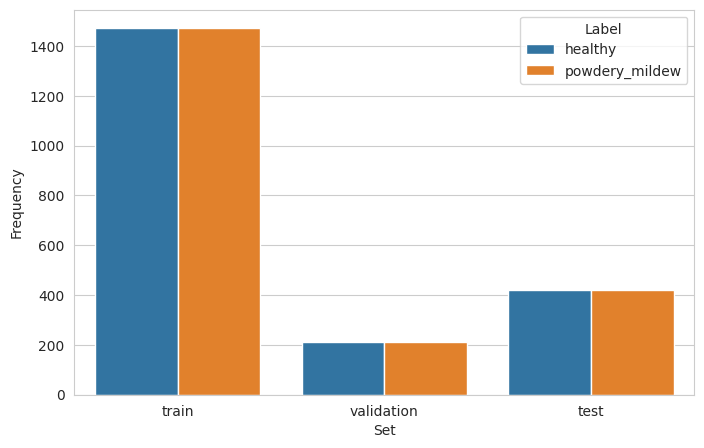

In [10]:
df_freq = pd.DataFrame([])
for folder in ['train', 'validation', 'test']:
    for label in labels:
        df_freq = df_freq.append(
            pd.Series(data={'Set': folder,
                            'Label': label,
                            'Frequency': int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))}
                      ),
            ignore_index=True
        )

        print(
            f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show()

## Pie Chart for Dataset Distribution

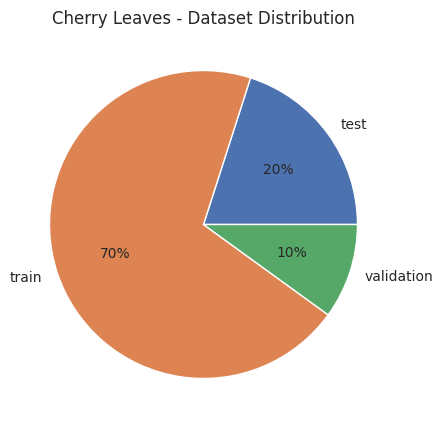

In [11]:
folders = os.listdir(my_data_dir)
data=[]
for folder in folders:
    for label in labels:
        n=int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))
        n+=n
    data.append(n)

px = 1/plt.rcParams['figure.dpi'] 
plt.subplots(figsize=(800*px, 500*px))
colors = sns.color_palette('deep')[0:5]
plt.pie(data, labels = folders, colors = colors, autopct='%.0f%%')
plt.title('Cherry Leaves - Dataset Distribution')
plt.savefig(f'{file_path}/sets_distribution_pie.png',
            bbox_inches='tight', dpi=150)
plt.show()

## Image Augmentation

### Import ImageDataGenerator

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Initialize ImageDataGenerator

In [13]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

### Augment Training Image Dataset for Model Training Purposes

In [14]:

batch_size = 20  # Set batch size
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True
                                                     )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Augment Validation Image Dataset for Model Validation Purposes

In [15]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Augment Test Image Dataset for Model Testing Purposes

In [16]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Plot Augmented TRAINING Image

(20, 256, 256, 3)


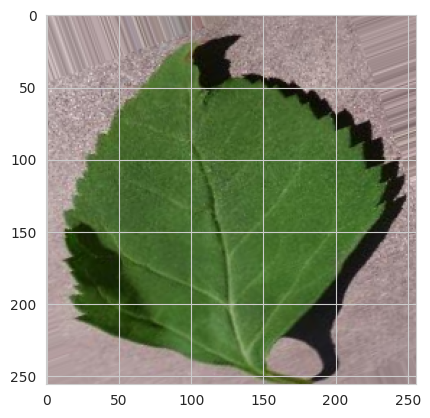

(20, 256, 256, 3)


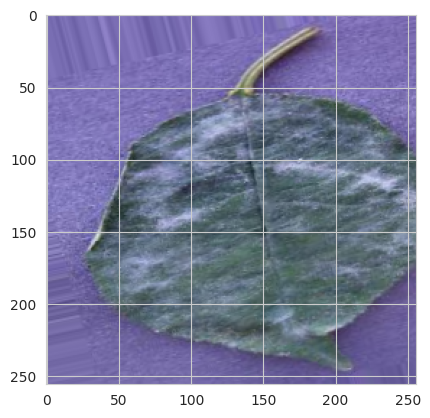

(20, 256, 256, 3)


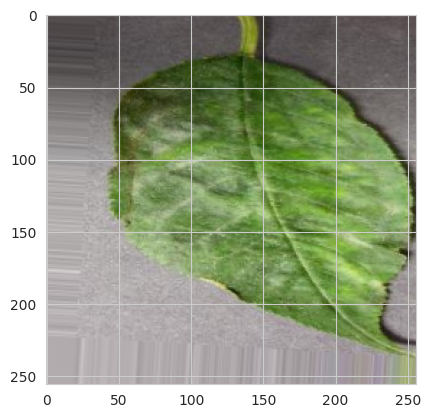

In [17]:
for _ in range(3):
    img, label = train_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

### Plot Augmented VALIDATION and TEST Images

(20, 256, 256, 3)


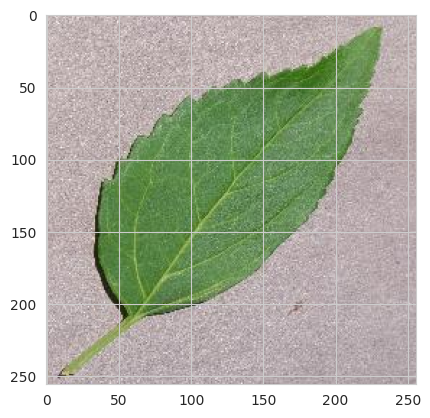

(20, 256, 256, 3)


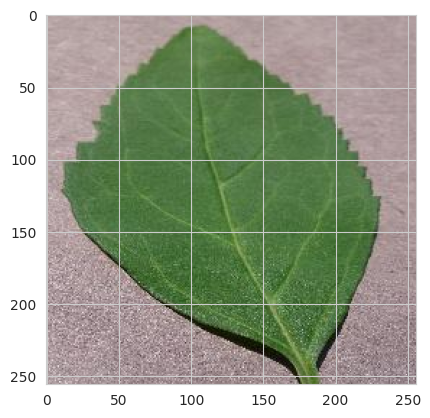

(20, 256, 256, 3)


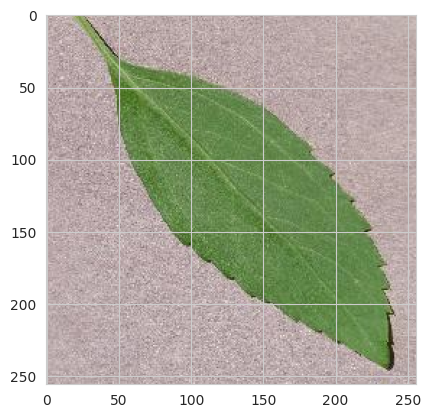

In [18]:
for _ in range(3):
    img, label = validation_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

### Plot Augmented TEST Images

(20, 256, 256, 3)


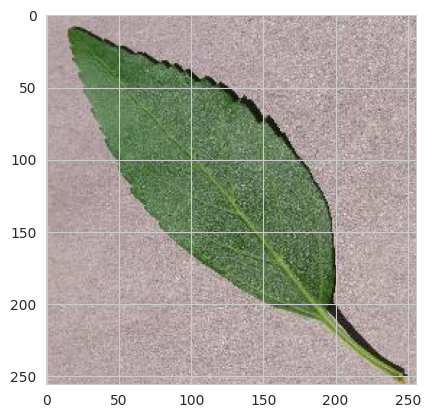

(20, 256, 256, 3)


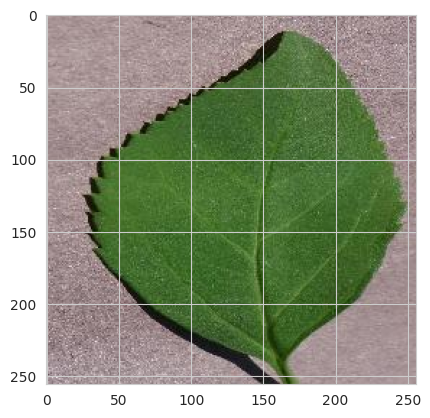

(20, 256, 256, 3)


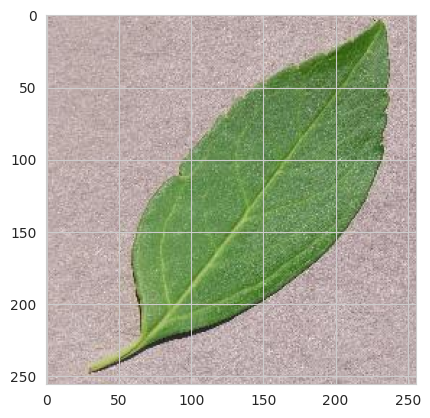

In [19]:

for _ in range(3):
    img, label = test_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

### Save Class Indices

In [20]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

## CNN Model 

### Import Model Packages

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import RMSprop, Adam, Adagrad

### Model Function

In [22]:
def create_tf_model():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))

    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adagrad',
                  metrics=['accuracy'])
    
    return model

### Model Summary

In [23]:
create_tf_model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 57600)             0

2024-04-21 16:44:15.335620: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Early Stopping 

In [24]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=3)

### Fit Model for Training

In [25]:
model = create_tf_model()
model.fit(train_set,
          epochs=18,
          steps_per_epoch = len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )

2024-04-21 16:44:15.694810: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/18
147/147 [==============================] - 145s 984ms/step - loss: 0.5641 - accuracy: 0.7220 - val_loss: 0.3959 - val_accuracy: 0.8857
Epoch 2/18
147/147 [==============================] - 145s 983ms/step - loss: 0.4223 - accuracy: 0.8119 - val_loss: 0.3388 - val_accuracy: 0.8595
Epoch 3/18
147/147 [==============================] - 139s 947ms/step - loss: 0.3503 - accuracy: 0.8495 - val_loss: 0.3174 - val_accuracy: 0.8524
Epoch 4/18
147/147 [==============================] - 149s 1s/step - loss: 0.3116 - accuracy: 0.8656 - val_loss: 0.2766 - val_accuracy: 0.9000
Epoch 5/18
147/147 [==============================] - 155s 1s/step - loss: 0.2883 - accuracy: 0.8728 - val_loss: 0.3443 - val_accuracy: 0.8429
Epoch 6/18
147/147 [==============================] - 141s 958ms/step - loss: 0.2748 - accuracy: 0.8827 - val_loss: 0.2217 - val_accuracy: 0.9190
Epoch 7/18
147/147 [==============================] - 140s 950ms/step - loss: 0.2614 - accuracy: 0.8899 - val_loss: 0.2105 - val_a

### Save Model 

In [26]:
model.save(f'outputs/{version}/mildew_detector_model.h5')

## Model Performance Analysis

### Model Learning Curve

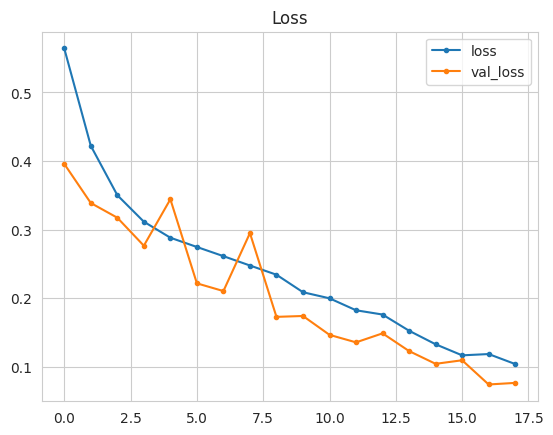

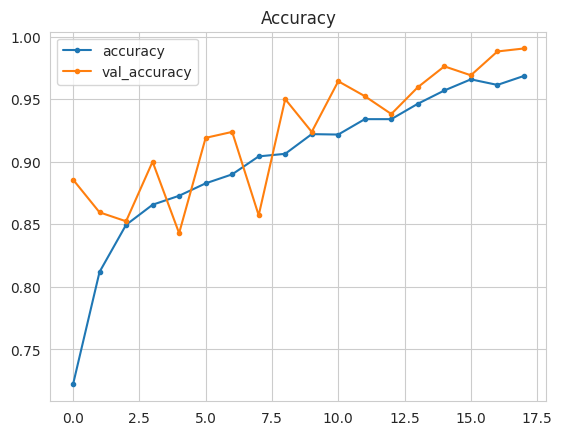

In [27]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss','val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png', bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy','val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png', bbox_inches='tight', dpi=150)
plt.show()

### Model Evaluation

#### Import Packages

In [28]:
import sklearn
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

Load saved model 

In [29]:
from keras.models import load_model
model = load_model(f'outputs/{version}/mildew_detector_model.h5')

Evaluate model on image Test set

In [30]:
evaluation = model.evaluate(test_set)

43/43 [==============================] - 10s 226ms/step - loss: 0.0646 - accuracy: 0.9846


### Save Evaluation Pickle File

In [31]:
joblib.dump(value=evaluation ,
            filename=f"outputs/{version}/evaluation.pkl")

['outputs/v1/evaluation.pkl']

### Confusion Matrix

In [32]:
validation_set.reset()

x_true, y_true = next(test_set)
preds = model.predict(test_set)
y_pred = np.rint(preds)
y_true = test_set.labels
print(confusion_matrix(y_true,y_pred))
print(classification_report(test_set.classes, y_pred, target_names=labels))

[[418   4]
 [  9 413]]
                precision    recall  f1-score   support

       healthy       0.98      0.99      0.98       422
powdery_mildew       0.99      0.98      0.98       422

      accuracy                           0.98       844
     macro avg       0.98      0.98      0.98       844
  weighted avg       0.98      0.98      0.98       844



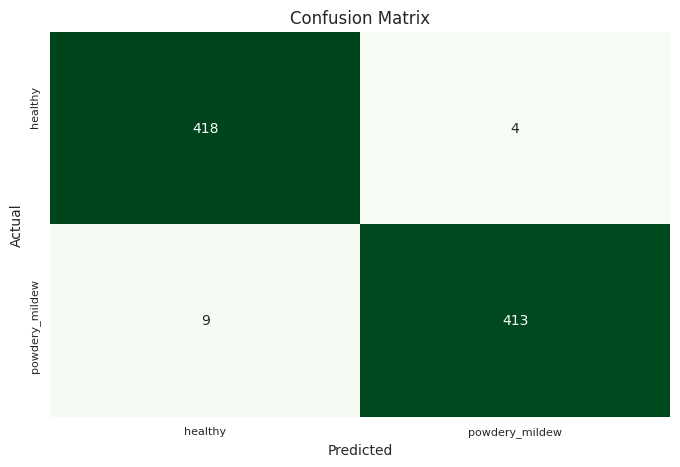

In [33]:
cm = confusion_matrix(y_true,y_pred)

classes=list(test_set.class_indices.keys()) 
length=len(classes)
plt.figure(figsize=(8, 5))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Greens', cbar=False, linewidths=0)       
plt.xticks(np.arange(length)+.5, classes, rotation= 0, fontsize=8)
plt.yticks(np.arange(length)+.3, classes, rotation=90, fontsize=8)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.savefig(f'{file_path}/confusion_matrix.png',
            bbox_inches='tight', dpi=150)
plt.show()

## Predict on Unseen Data

### Load a random image as PIL

Image shape: (256, 256), Image mode: RGB


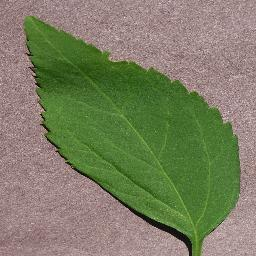

In [34]:
from tensorflow.keras.preprocessing import image

pointer = 66 
label = labels[0] # select Healthy[0] or Infected[1]

pil_image = image.load_img(test_path + '/'+ label + '/'+ os.listdir(test_path+'/'+ label)[pointer],
                          target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

### Convert Image to Array

In [35]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 256, 256, 3)


### Predict Class Probabilities

In [36]:
pred_proba = model.predict(my_image)[0,0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class =  target_map[pred_proba > 0.5]  

if pred_class == target_map[0]: pred_proba = 1 - pred_proba

print(pred_proba)
print(pred_class)

0.9836714565753937
healthy


## Conclusions

- A CNN model with Adagrad optimizer algorithm was created. This model showed good performance in the accuracy and loss plots and the confusion matrix showed positive results, with no signs of overfitting.
- The model was successful in achieving the required 97% accuracy as outlined by the client.